In [1]:
# Importing libraries

import re
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import yaml
from git_root import git_root
from transformers import AutoTokenizer

In [2]:
# adding git_root and local imports
my_git_root = git_root()
sys.path.append(my_git_root)

from src import flatten, contains_text, extract_table

In [3]:
# importing data
df_documents_path = f'{my_git_root}/data/documents_cleaned.csv'
df_documents = pd.read_csv(df_documents_path)

In [4]:
# importing settings
with open(f'{my_git_root}/settings.yaml', 'r') as file:
    settings = yaml.safe_load(file)

print(settings)

sentence_transformer_model_name = settings['sentence_transformer_model_name']
sentence_transformer_max_tokens = settings['sentence_transformer_max_tokens']

{'sentence_transformer_model_name': 'thenlper/gte-small', 'sentence_transformer_max_tokens': 512, 'llm_model_name': 'tiiuae/Falcon3-7B-Instruct'}


In [5]:
# initializing tokenizer
tokenizer = AutoTokenizer.from_pretrained(sentence_transformer_model_name)

In [6]:
df_documents

,name,text
0,aalto-university.md,# Aalto University \n\n## Aalto University Re...
1,aberystwyth-university.md,# Research Data Management Policy \n\nVersion...
2,aston-university.md,# Research Data Management Policy \n\nJuly 20...
3,bangor-university.md,# Data Protection Policy \n\n Rev Date Purpos...
4,brunel-university-london.md,# Brunel University Research Data Management P...
...,...,...
137,universität-rostock.md,# Research Data Policy of the University of Ro...
138,universität-siegen.md,# Research-Data-Policy of the University of Si...
139,universität-stuttgart.md,# Research data management policy of the Unive...
140,utrecht-university.md,# University policy framework for research dat...


In [7]:
document_names = df_documents['name'].to_list()
documents = df_documents['text'].to_list()

In [8]:
def remove_empty_chunks(document):
    return [chunk for chunk in document if chunk is not None and bool(re.search(r'[a-zA-Z]+', chunk))]

In [9]:
def chunk_document_regex(document, regex_pattern):
    document_chunked = re.split(regex_pattern, document)
    document_chunked = remove_empty_chunks(document_chunked)
    return document_chunked

In [10]:
def chunk_document_by_delimiter_type(document, regex_delimiters):
    documents_chunked = []
    for key, value in regex_delimiters.items():
        documents_chunked.append(chunk_document_regex(document, value))

    documents_chunked_len = [len(document_chunked) for document_chunked in documents_chunked]
    max_index = np.argmax(documents_chunked_len)
    max_len = documents_chunked_len[max_index]
    return documents_chunked, max_index, max_len

In [11]:
def chunk_document(document, chunk_levels):
    result = []
    headings_level = chunk_levels.count('headings') + 1
    list_level = chunk_levels.count('list') + 1

    delimiters = {
        'explicit_delimiters': {
            'headings': rf'\s*#{{1,{headings_level}}}\s*',
            'list': rf'\n\s*#*\s*\d+\.(\d+\.?){{0,{list_level-1}}}\s+',
        },

        'implicit_delimiters' : {
            'paragraphs': r'\s*\n\s*\n\s*',
        },

        'fallback_delimiters' : {
            'newlines': r'\s*\n\s*',
            'list_no_newlines': rf'#*\s*\d+\.(\d+\.?){{0,{list_level-1}}}\s+',
        }
    }

    for delimiter_type in delimiters.keys():
        documents_chunked, max_index, max_len = chunk_document_by_delimiter_type(document, delimiters[delimiter_type])
        my_delimiter = list(delimiters[delimiter_type].keys())[max_index]
        if max_len > 1:
            chunk_levels.append(my_delimiter)
            document_chunked = documents_chunked[max_index]
            break
    else:
        assert False, 'Cannot find any delimiters'

    for chunk in document_chunked:
        chunk_tokens = tokenizer.tokenize(chunk)
        if len(chunk_tokens) <= sentence_transformer_max_tokens:
            result.append(chunk)
        else:
            result.append(chunk_document(chunk, chunk_levels))

    return result


In [12]:
chunked_documents = [chunk_document(document, list()) for document in documents]
chunked_documents = [flatten(chunk) for chunk in chunked_documents]

In [13]:
chunked_documents_names = []

for i, chunked_document in enumerate(chunked_documents):
    chunked_document_flat = flatten(chunked_document)
    chunked_document_flat_num_chunks = len(chunked_document_flat)
    chunked_documents_names.extend([document_names[i]] * chunked_document_flat_num_chunks)

chunked_documents_flat = flatten(chunked_documents)

In [14]:
num_tokens = []

for chunk in chunked_documents_flat:
    tokens = tokenizer.tokenize(chunk)
    num_tokens.append(len(tokens))

In [15]:
df = pd.DataFrame(data={
    'name': chunked_documents_names,
    'text': chunked_documents_flat,
    'num_tokens': num_tokens,
})

In [16]:
df

,name,text,num_tokens
0,aalto-university.md,Aalto University,3
1,aalto-university.md,Aalto University Research Data Management Policy,7
2,aalto-university.md,The research data management policy aims to ma...,89
3,aalto-university.md,The data management policy shall be implemente...,104
4,aalto-university.md,Ownership of copyright protected research data...,77
...,...,...,...
3481,wrexham-university.md,"FAIR Data\n\nWhere it is lawful to do so, the ...",96
3482,wrexham-university.md,Prifysgol Wrecsam Wrexham University\n\nPublic...,80
3483,wrexham-university.md,Reporting a Data Incident/Breach\n\nThe UK GDP...,125
3484,wrexham-university.md,"Other Polices, Procedures, Legislation\n\nThis...",51


(array([553., 465., 452., 360., 283., 227., 177., 152., 124.,  71.,  68.,
         71.,  64.,  66.,  54.,  32.,  35.,  28.,  23.,  20.,  30.,  19.,
         19.,  18.,  20.,  10.,  16.,   8.,  10.,  11.]),
 array([  1.        ,  18.03333333,  35.06666667,  52.1       ,
         69.13333333,  86.16666667, 103.2       , 120.23333333,
        137.26666667, 154.3       , 171.33333333, 188.36666667,
        205.4       , 222.43333333, 239.46666667, 256.5       ,
        273.53333333, 290.56666667, 307.6       , 324.63333333,
        341.66666667, 358.7       , 375.73333333, 392.76666667,
        409.8       , 426.83333333, 443.86666667, 460.9       ,
        477.93333333, 494.96666667, 512.        ]),
 <BarContainer object of 30 artists>)

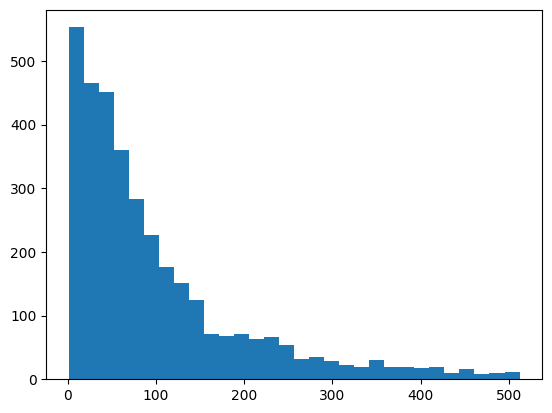

In [17]:
plt.hist(num_tokens, bins=30)

In [39]:
df.to_csv(f'{my_git_root}/data/chunked_documents_final.csv', index=False)

# Looking through Documents

In [40]:
index = 5

In [41]:
document_names[index]

'buckinghamshire-new-university.md'

In [42]:
print(documents[index])

# RESEARCH DATA MANAGEMENT POLICY  

## Table of Contents  

Introduction... 3   
Purpose ... 3   
Scope.... 4   
Responsibilities of the University... 4   
Responsibilities of the Researchers. 4   
Other relevant University policies. 6   
Useful resources.... 6   
Definitions .... 6   
Appendix: Equality Impact Assessment.. 8  

## Approved by:  

Committee responsible for approval  

## Date first published: Jun-2016  

## Owner:  

Date updated: Sep-2024   
Review Date: Sep-2029  

Director of Research and Enterprise  

This document has been designed to be accessible for readers. However, should you require the document in an alternative format please contact the University Secretariat.  

© Buckinghamshire New University  

## Introduction  

1 The effective management of research data is crucial for ensuring the integrity, reproducibility, and impact of scholarly work. Buckinghamshire New University (BNU) is committed to upholding the highest standards of academic research by imp

In [43]:
for chunk in chunked_documents[index]:
    print(chunk)
    print('-'*50)

RESEARCH DATA MANAGEMENT POLICY
--------------------------------------------------
Table of Contents  

Introduction... 3   
Purpose ... 3   
Scope.... 4   
Responsibilities of the University... 4   
Responsibilities of the Researchers. 4   
Other relevant University policies. 6   
Useful resources.... 6   
Definitions .... 6   
Appendix: Equality Impact Assessment.. 8
--------------------------------------------------
Approved by:  

Committee responsible for approval
--------------------------------------------------
Date first published: Jun-2016
--------------------------------------------------
Owner:  

Date updated: Sep-2024   
Review Date: Sep-2029  

Director of Research and Enterprise  

This document has been designed to be accessible for readers. However, should you require the document in an alternative format please contact the University Secretariat.  

© Buckinghamshire New University
--------------------------------------------------
Introduction  

1 The effective man